<a href="https://colab.research.google.com/github/sakamototaisei/python_colab/blob/main/AI%E3%81%A7%E6%9D%A1%E4%BB%B6%E4%BB%98%E3%81%AE%E6%89%8B%E6%9B%B8%E3%81%8D%E6%96%87%E5%AD%97%E3%82%92%E7%94%9F%E6%88%90_GAN%E3%81%A7%E5%AD%A6%E3%81%B6%E7%94%9F%E6%88%90%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **生成モデルについて**

## **画像認識との違い：識別モデルと生成モデル**

**識別モデル**

*   入力情報/画像に対して、どのクラスであるか予測

**生成モデル**

*   入力情報に画像や乱数を与え→生成モデル→出力情報を生み出す

## **生成モデルの種類Part1_オートエンコーダー**

**オートエンコーダー：自己符号化器**

*   入力と出力が同じ値に
*   ReLU関数により、事前学習は不要になった

## **生成モデルの種類Part2_VAE**

**VAE：変分自己符号化器**

*   出力が潜在変数によって決まる

## **生成モデルの種類Part3_GAN**

**GAN：敵対的生成ネットワーク**

*   「生成器」により偽物を生成し、本物と偽物を「識別器」によって判定する
*   「生成器」の学習によって、「識別器」が正しく判断できなくなる出力0.5を目指す

# **様々なGAN**

## **無垢に生まれたVanillaGAN**

*   最もシンプルなGAN

## **画像に強いDCGAN**

*   上記のニューラルネットワークの部分を畳み込み層に置き換えたもの(識別器、生成器)
*   解像度を4倍に増やしても、畳み込みの重み共有によりパラメータの数を減らすことができる、綺麗な画像を表現しつつ学習時間を短縮



## **条件付きのConditional GAN**

*   生成器や識別器に入力ノイズに条件を付ける、どの数字を生成しているのかなど

## **組み合わせのConditional DCGAN**

*   DCGANとConditionalv GANを組み合わせてもの

# **手書き文字を生み出そう：ソフトウェアコーディング**

## **ライブラリの読み込み**

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [121]:
torch.__version__

'2.0.1+cu118'

## **データセットの読み込み**

In [122]:
# 画像サイズ
img_size = 32

# バッチサイズ、一度に学習できる画像の数になる
batch_size = 128

In [123]:
# 読み込むデータの加工方式
data_transforms = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]) # RGBの場合は[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
    ]
)

train_datasets = datasets.MNIST(root='./datasets',
                                train=True, download=True,
                                transform=data_transforms)

loaders = DataLoader(train_datasets, batch_size=batch_size, shuffle=True)

In [124]:
next(iter(loaders))

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         ...,
 
 
         [[[-1., -1., -1.,  ..., -

In [125]:
# 画像データの取得
next(iter(loaders))[0].shape

torch.Size([128, 1, 32, 32])

## **画像を表示させる**

In [126]:
def im_show(image):
    print(image.shape)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    im = image.detach().numpy()
    im = im.transpose(1, 2, 0) # c h w → h w c
    # ノーマライゼーションの処理、暗い画像明るい画像を均等にする
    im = std * im + mean
    plt.imshow(im)

torch.Size([1, 32, 32])


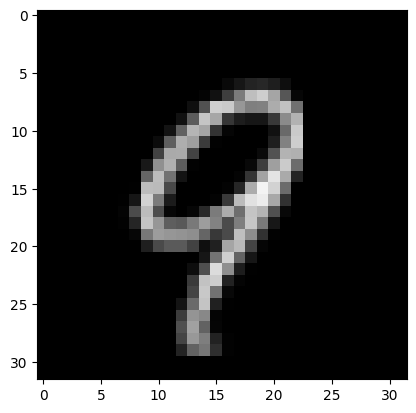

In [127]:
im_show(next(iter(loaders))[0][0])

## **入力ノイズの生成**

In [128]:
def create_noise(batch_size):
    # torch.randn() 正規分布を自動生成してくれるメソッド
    z = torch.randn((batch_size, 100, 1, 1)) # 正規乱数 -3.0 ~ 3.0
    return z.cuda()

In [129]:
create_noise(1)

tensor([[[[-0.1245]],

         [[-0.9080]],

         [[-0.5031]],

         [[-1.7367]],

         [[ 1.2885]],

         [[-0.5312]],

         [[-0.5765]],

         [[-1.4668]],

         [[ 1.0399]],

         [[ 1.1323]],

         [[ 0.2333]],

         [[-0.8714]],

         [[-1.2953]],

         [[-1.3717]],

         [[-0.6865]],

         [[-0.0298]],

         [[ 0.0686]],

         [[-0.4085]],

         [[-0.6002]],

         [[-0.5671]],

         [[-1.1628]],

         [[-1.0845]],

         [[-0.6744]],

         [[ 1.2884]],

         [[ 0.1652]],

         [[ 0.5442]],

         [[ 2.0186]],

         [[-1.3088]],

         [[-1.6514]],

         [[ 1.1790]],

         [[ 1.0282]],

         [[ 0.5331]],

         [[-0.4104]],

         [[ 0.0462]],

         [[-0.2738]],

         [[ 2.0798]],

         [[-0.5912]],

         [[-0.4462]],

         [[ 0.2890]],

         [[-1.6174]],

         [[-1.2601]],

         [[-0.9638]],

         [[ 0.1830]],

         [[

In [130]:
z = create_noise(1)
print('max', z.max())
print('min', z.min())

max tensor(2.7233, device='cuda:0')
min tensor(-2.6201, device='cuda:0')


## **条件ラベルの生成**

In [131]:
# 生成器に使う単位行列
def create_1hot_vector():
    label_1hots = torch.zeros(10, 10)
    for i in range(10):
        label_1hots[i, i] = 1
    label_1hots = label_1hots.view(10, 10, 1, 1).cuda()
    return label_1hots

In [132]:
# 生成器に使う単位行列を生成
label_1hots = create_1hot_vector()
label_1hots.view(10, 10)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [133]:
# 識別器に使う単位行列
def create_filled_label():
    # 4次元の生成
    label_fills = torch.zeros(10, 10, img_size, img_size)
    # 画像のワンホットベクトル
    ones = torch.ones(img_size, img_size)
    for i in range(10):
        label_fills[i][i] = ones
    return label_fills.cuda()

In [134]:
label_fills = create_filled_label()
label_fills[1]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

## **Generatorの作成**

In [203]:
class Generator(nn.Module):
    # 初期化
    def __init__(self):
        super(Generator, self).__init__()
        # 入力チャンネルのベースとなる値を設定
        d = 128
        # 転置畳み込み
        self.deconv1s = nn.ConvTranspose2d(100, d*2, kernel_size=4, stride=1, padding=0)
        # 画像情報の偏りをなくす
        self.deconv1s_bn = nn.BatchNorm2d(d*2)
        # ターゲットラベル
        self.deconv1t = nn.ConvTranspose2d(10, d*2, 4, 1, 0)
        self.deconv1t_bn = nn.BatchNorm2d(d*2)
        # ---　ここまでが入力層側のパラメータの設定 ---

        # 第二層上記2つを足し合わせて2倍になっている
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        # 第三層
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        # 第四層
        self.deconv4 = nn.ConvTranspose2d(d*2, 1, 4, 2, 1)


    # 重みの初期化
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # 順伝播処理
    def forward(self, input_, label):
        x = F.relu(self.deconv1s_bn(self.deconv1s(input_)))
        y = F.relu(self.deconv1t_bn(self.deconv1t(label)))

        # xとyをチャンネル方向に足し合わせる
        x = torch.cat([x, y], 1)

        # ２層目3層目4層目
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = torch.tanh(self.deconv4(x))

        return x

In [204]:
Generator()

Generator(
  (deconv1s): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
  (deconv1s_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1t): ConvTranspose2d(10, 256, kernel_size=(4, 4), stride=(1, 1))
  (deconv1t_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

## **Discriminatorの作成**

In [195]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 入力チャンネルを64と指定
        d = 64

        # Generatorと逆のことをしてくイメージ
        self.conv1s = nn.Conv2d(1, d, 4, 2, 1)
        # ターゲットラベル
        self.conv1t = nn.Conv2d(10, d, 4, 2, 1)

        self.conv2 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*4)

        self.conv3 = nn.Conv3d(d*4, d*8, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*8)

        self.conv4 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # 重みの初期化
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # 順伝播
    def forward(self, input_, label):
        x = F.leaky_relu(self.conv1s(input_), 0.2) # leaky_relu 0.2
        y = F.leaky_relu(self.conv1t(label), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = torch.sigmoid(self.conv4(x))
        return x

In [196]:
Discriminator()

Discriminator(
  (conv1s): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1t): Conv2d(10, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)

## **重みの初期化**

In [197]:
def normal_init(m, mean, std):
    # 転置畳み込みまたは畳み込みのモジュールであった場合に
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        # モジュールの重みのデータを正規化する
        m.weight.data.normal_(mean, std)
        # バイアスを0に初期化している
        m.bias.data.zero_()

In [198]:
sample = Generator()
# Generatorの転置畳み込み1層目の画像の重みを取得
w = sample.deconv1s.weight
print('初期値', w.max())
# 重みの初期化関数を呼び出す
sample.weight_init(mean=0.0, std=0.02) # 0.0, 0.02
print('変更後', w.max())

# 重みが大きくなる

初期値 tensor(0.0156, grad_fn=<MaxBackward1>)
変更後 tensor(0.0951, grad_fn=<MaxBackward1>)


## **インスタンス化**

In [199]:
# ハイパーパラメーターとして学習係数を定義
learning_rate = 0.0002

# 条件ラベルをインスタンス化
label_1hots = create_1hot_vector()
label_fills = create_filled_label()

# 学習モデルをインスタンス化
G = Generator().cuda()
D = Discriminator().cuda()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

# 学習する上での最適化の処理を初期化する
optimizer_G = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999)) # Adam 0.5, 0.999
optimizer_D = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# 損失関数を設定
BCE_loss = torch.nn.BCELoss()

In [200]:
# Discriminatorの教師ラベルを作成と自動微分化 Variable
t_real = Variable(torch.ones(batch_size)).cuda()
t_fake = Variable(torch.zeros(batch_size)).cuda()

# 学習推移のログ
loss_list = {}
loss_list['loss_G'] = []
loss_list['loss_D'] = []

## **学習ループ**

In [201]:
# ハイパーパラメーターの設定
epochs = 10

# 継続の場合は、途中の番号を設定
epoch_from = 1

In [202]:
for epoch in range(epoch_from, epochs + 1):
    print('epoch', epoch)
    # 画像データとその画像がどの数字であったかというセットを取得
    for i, (x_batch, t_batch) in enumerate(loaders): # x_betch, t_batch

        # 取得したミニバッチのサイズ
        N = len(x_batch)

        label_1hot = label_1hots[t_batch]
        label_fill = label_fills[t_batch]

        # Generatorの損失を計算
        # ノイズを作成
        z =create_noise(N)
        # 作り出したフェイク画像と、どの画像を作り出したかというラベルを与えて、これが本物であるか偽物であるか判定させる
        fake = G(z, label_1hot)
        # .squeeze()複雑な配列の要素を綺麗にまとまった形で成形して取り出す
        pred = D(fake, label_fill).squeeze()
        # 予測したpred変数が本当の値t_realとどれだけ誤差があるか計算
        loss_G = BCE_loss(pred, t_real[0:, N])
        loss_list['loss_G'].append(loss_G)

        # Generatorの損失を元にパラメーターを更新
        # 勾配を初期化
        optimizer_G.zero_grad()
        # 誤差逆伝播
        loss_G.backward()
        # パラメータの更新,
        optimizer_G.step()

        # Discriminatorの本物と偽物の損失をそれぞれ計算
        # # 本物の損失を計算 本物の画像を取得
        real = Variable(x_batch).cuda()
        pred = D(real, label_fill).squeeze()
        loss_D_real = BCE_loss(pred, t_real[0: N])

        # 偽物の損失
        z = create_noise(N)
        # フェイク画像を取得
        fake = G(z, label_1hot)
        # ファいく画像をデタッチとして整形して入力する
        pred = D(fake.detach(), label_fill).squeeze()
        loss_D_fake = BCE_loss(pred, t_fake[0: N])

        # 2つの損失を足し合わせる
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_list['loss_D'].append(loss_D)

        # Discriminatorのパラメーターを更新する
        # 勾配を初期化
        optimizer_D.zero_grad()
        # 誤差逆伝播
        loss_D.backward()
        # パラメータの更新,
        optimizer_D.step()

        # 100回に1度ログを表示させる
        if i % 100 == 0:
            print('G: %.4f D: %.4f' %(loss_G, loss_D))

    epoch += 1

    # 学習係数の減衰
    if epoch == 5:
        optimizer_G.param_groups[0]['lr'] = learning_rate/2
        optimizer_D.param_groups[0]['lr'] = learning_rate/2
    elif epoch == 7:
        optimizer_G.param_groups[0]['lr'] = learning_rate/4
        optimizer_D.param_groups[0]['lr'] = learning_rate/4
    elif epoch == 9:
        optimizer_G.param_groups[0]['lr'] = learning_rate/8
        optimizer_D.param_groups[0]['lr'] = learning_rate/8

epoch 1


RuntimeError: ignored